In [1]:
import json
import math
import itertools
from collections import defaultdict, Counter
import numpy as np
from scipy.stats import spearmanr, shapiro, mannwhitneyu
from sklearn.cluster import SpectralClustering
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
%matplotlib inline

In [6]:
def build_graph(start_year, end_year):  
    if(end_year == -1):
        # Load data
        artists_dict = json.load(open(f"1000 artists different 2013-2023/artists_{start_year}.json", "r"))
        related_dict = json.load(open(f"1000 artists different 2013-2023/related_{start_year}.json", "r"))

        # Build graph
        G = nx.Graph()
        for artist, related in related_dict.items():
            for next_artist in related:
                G.add_edge(artist, next_artist)
    else:
        # Load data
        artists_dict = {}
        artist_id_set = set()
        related_dict = {}
        for year in range(start_year, end_year+1):
            #dictionary {key: {artist information}}
            year_artist_dict = json.load(open(f"data/artists_{year}.json", "r")) 
            for year_artist in year_artist_dict.keys():
                #check if artist id is currently in the set...
                year_artist_id = year_artist_dict[year_artist]["artist_id"]
                if year_artist_id not in artist_id_set:
                    artist_id_set.add(year_artist_id)
                    #right now I keep the earliest information of a repeating artist -- should I be updating it to be the latest -- that would be complicated...
                    artists_dict[year_artist]=year_artist_dict[year_artist] 

            #dictionary {artist id: {list of related artist ids}}
            year_related_dict = json.load(open(f"data/related_{year}.json", "r")) 
            for year_related_id in year_related_dict.keys():
                if year_related_id not in related_dict:
                    # add new key value pair to related_dict
                    related_dict[year_related_id]=year_related_dict[year_related_id]
                else:
                    # update the values for the key in related_dict
                    related_dict[year_related_id]=list(set(related_dict[year_related_id]+year_related_dict[year_related_id]))
        # Build graph
        G = nx.Graph()
        for artist, related in related_dict.items():
            for next_artist in related:
                G.add_edge(artist, next_artist)

    return G, artists_dict

In [3]:
# Partition graph
def partition_graph(n, graph):
    comp = nx.community.girvan_newman(graph)
    limited = itertools.takewhile(lambda c: len(c) <= n, comp)
    return list(limited)[-1]

In [4]:
#Get most common genre in partition
def get_name(node_list, artists_dict, idf):
    counts = defaultdict(int)
    for node in node_list:
        genres = artists_dict[node]["genres"]
        for genre in genres:
            counts[genre.replace(" ", "_")] += 1
    tf_idf = {k: v * idf[k] for k, v in counts.items()}
    return max(tf_idf, key=tf_idf.get)

In [5]:
# Generate colors and labels for graph
def graph_fav_artist(G, communities, cluster_labels):
    colors = []
    for node in G.nodes():
        for i in range(len(communities)):
            if node in communities[i]:
                colors.append(i)
    
    # Draw graph
    fig, ax = plt.subplots(figsize=(15,15))
    cm = plt.colormaps["tab20"]
    color_map = cm(range(len(communities)+1))
    pos=nx.spring_layout(G)
    for i, cluster in enumerate(communities):
        nx.draw_networkx_nodes(G, pos=pos, node_size=10, nodelist=cluster, ax=ax, node_color=[color_map[i+1]], 
                            linewidths=0.1, edgecolors='k', label=cluster_labels[i])
    nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color="#929591", width=0.5)
    ax.axis("off")
    fig.set_facecolor('k')
    lgnd = ax.legend(scatterpoints=1)
    for handle in lgnd.legend_handles:
        handle.set_sizes([20.0])
    plt.show()

In [28]:
def cluster_quality(G,communities):
    # Count links within and between clusters
    intra_cluster_links = 0  # To store total number of links within each cluster
    inter_cluster_links = set()  # To store unique links between clusters

    for community in communities:
        # Create a subgraph for the current community
        subgraph = G.subgraph(community)

        # Count the number of edges within the community
        intra_cluster_links += subgraph.number_of_edges()

        # Count the number of unique edges between the current community and other communities
        for node in community:
            neighbors = set(G.neighbors(node))
            for neighbor in neighbors:
                if neighbor not in community:
                    inter_cluster_links.add(tuple(sorted((node, neighbor))))  # Convert to tuple to make it hashable

    # Print the number of links within each cluster and between clusters
    # print("Number of links within each cluster:", intra_cluster_links)
    # print("Number of unique links between clusters:", len(inter_cluster_links))

    # Calculate the total number of edges
    total_edges = intra_cluster_links + len(inter_cluster_links)
    # print("Total number of edges:", total_edges)

    # Check if there are any edges counted as both intra-cluster and inter-cluster links
    common_edges = inter_cluster_links.intersection(G.edges())
    # if common_edges:
    #     print("Edges counted as both intra-cluster and inter-cluster links:", common_edges)
    
    return intra_cluster_links/total_edges, len(inter_cluster_links)/total_edges



In [41]:
def WCSS(communities, G):
    wcss = 0
    for community in communities:
        # Create a subgraph for the current community
        subgraph = G.subgraph(community)
        node_positions = nx.spring_layout(subgraph)  # You can use any layout algorithm here
        node_positions_array = np.array(list(node_positions.values()))
        centroid = np.mean(node_positions_array, axis=0)
        
        for node_id in node_positions:
            node_position = node_positions[node_id]
            squared_distances = np.linalg.norm(node_position - centroid)  ** 2
            wcss += squared_distances
    return wcss
            

In [50]:
import networkx.algorithms.community as nx_comm

def girvan_newman(G, min_clusters, max_clusters):
    modularity_scores = []
    cluster_counts = []
    communities_generator = nx_comm.girvan_newman(G)
    
    for communities in communities_generator:
        num_clusters = len(communities)
        if num_clusters < min_clusters:
            continue
        if num_clusters > max_clusters:
            break
        modularity = nx_comm.modularity(G, communities)
        modularity_scores.append(modularity)
        cluster_counts.append(num_clusters)

    return cluster_counts, modularity_scores

Graph for year 2016


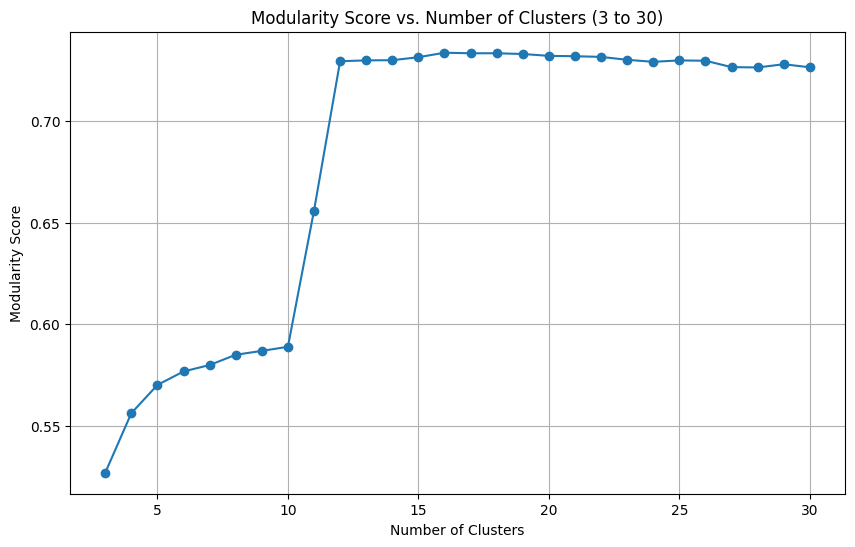

In [53]:
#graphing individual year trends

#years = [2013, 2023]

for year in range(2016,2017):
    G, artists_dict = build_graph(year, -1)
    print(f"Graph for year {year}")

    # Print basic graph properties
    # print("Number of nodes: ", G.number_of_nodes())
    # print("Number of edges: ", G.number_of_edges())
    # print("Connected components: ", nx.number_connected_components(G))
    # print("Average clustering coefficient: ", nx.average_clustering(G))

    # Clusters
    # num_clusters = 3 #originally 30
    # elbow_data = []
    # for i in range (3, 10):
    #     num_clusters = i
    #     communities = partition_graph(num_clusters, G) 
        # intra_prop, inter_prop = cluster_quality(G,communities)
        # print("numclusters", num_clusters, "INTRA", intra_prop, "INTER", inter_prop)
        # want inter LOW, intra HIGH
        
        # wcss = WCSS(communities, G)
        # elbow_data.append(wcss)

    # Calculate modularity scores from 3 to 30 clusters
    gn_cluster_range_adjusted, gn_modularity_scores_adjusted = girvan_newman(G, 3, 30)

    # Plotting the modularity scores
    plt.figure(figsize=(10, 6))
    plt.plot(gn_cluster_range_adjusted, gn_modularity_scores_adjusted, marker='o')
    plt.title("Modularity Score vs. Number of Clusters (3 to 30)")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Modularity Score")
    plt.grid(True)

    # plt.figure(figsize=(8, 6))
    # plt.plot(range(3, 10), elbow_data, marker='o', linestyle='-', color='b')
    # plt.title('Elbow Method')
    # plt.xlabel('Number of Clusters')
    # plt.ylabel('WCSS')
    # plt.xticks(np.arange(1, 11, 1))
    # plt.grid(True)
    # plt.show()

    # # Compute inverse document frequencies
    # idf = defaultdict(int)
    # for partition in communities:
    #     genres = ["#".join(artists_dict[node]["genres"]) for node in partition]
    #     doc = "#".join(genres).replace(" ", "_").replace("#", " ")
    #     unique = set()
    #     for term in doc.split():
    #         if term not in unique:
    #             idf[term] += 1
    #             unique.add(term)
    # idf = {k:math.log(len(communities)/v) for k, v in idf.items()}

    # # Get center of each partition
    # labels = {}
    # cluster_labels = []
    # for community in communities:
    #     sub = G.subgraph(list(community))
    #     sub_close = nx.closeness_centrality(sub)
    #     center = max(sub_close, key=sub_close.get)
    #     name = get_name(list(community), artists_dict, idf).replace("_", " ")
    #     labels[center] = name
    #     cluster_labels.append(name)
    #     print(artists_dict[center]["name"], name)

    # #draw graph
    # graph_fav_artist(G, communities, cluster_labels)
    # print("-----------------------------")



Graph for years 2013-2023
Number of nodes:  668
Number of edges:  1797
Connected components:  4
Average clustering coefficient:  0.28682976756680517
Disclosure big beat
Imagine Dragons pop
Robin Thicke contemporary r&b
Hoodie Allen indie pop rap
Hucci electronic trap
Post Malone rap
Glass Animals indie rock
Alex Ubago latin pop
DDG florida drill
Morgan Wallen contemporary country


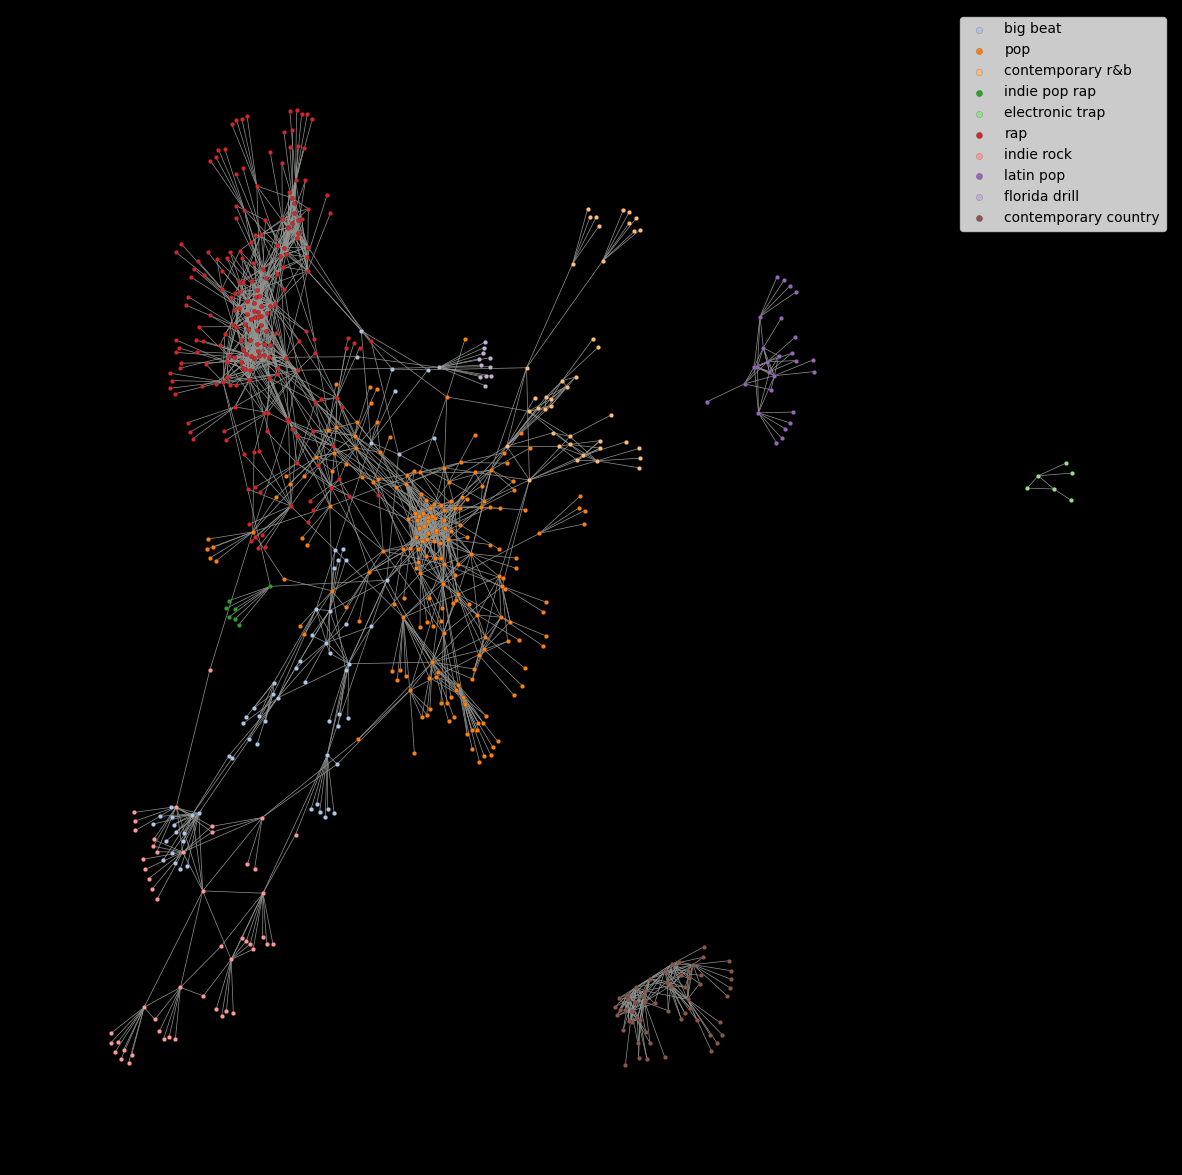

-----------------------------


In [7]:

# graphing cumulative years
# ex: 2013-2015, 2013-2023
# year_ranges = [(2013,2015),(2013,2023)]
year_ranges = [(2013,2023)]

for start_year,end_year in year_ranges:
    G, artists_dict = build_graph(start_year,end_year)
    print(f"Graph for years {start_year}-{end_year}")

    # Print basic graph properties
    print("Number of nodes: ", G.number_of_nodes())
    print("Number of edges: ", G.number_of_edges())
    print("Connected components: ", nx.number_connected_components(G))
    print("Average clustering coefficient: ", nx.average_clustering(G))

    # Clusters
    num_clusters = 10 #originally 30
    communities = partition_graph(num_clusters, G) 

    # # Compute inverse document frequencies
    idf = defaultdict(int)
    for partition in communities:
        genres = ["#".join(artists_dict[node]["genres"]) for node in partition]
        doc = "#".join(genres).replace(" ", "_").replace("#", " ")
        unique = set()
        for term in doc.split():
            if term not in unique:
                idf[term] += 1
                unique.add(term)
    idf = {k:math.log(len(communities)/v) for k, v in idf.items()}

    # Get center of each partition
    labels = {}
    cluster_labels = []
    for community in communities:
        sub = G.subgraph(list(community))
        sub_close = nx.closeness_centrality(sub)
        center = max(sub_close, key=sub_close.get)
        name = get_name(list(community), artists_dict, idf).replace("_", " ")
        labels[center] = name
        cluster_labels.append(name)
        print(artists_dict[center]["name"], name)

    #draw graph
    graph_fav_artist(G, communities, cluster_labels)
    print("-----------------------------")